# Exercise UD1.2.3 Anharmonic Baths

**Compute the norm of $T_2$ as a function of the dissipative rate of the harmonic oscillator** $\kappa$.


The code provided simulates the master equation of a two-level system coupled to a dissipative harmonic oscillator in contact with a bath at temperature $T$

The evolution / dynamics of the total system can be described as
$$\frac{d\rho}{dt}=L\rho$$
with 
$$L\rho=-i[H,\rho]+\kappa(n_{th}+1)(2a\rho a^\dagger-a^\dagger a \rho-\rho a^\dagger a)+\kappa(n_{th})(2a^\dagger\rho a-a a^\dagger \rho-\rho a a^\dagger)$$
where $\kappa$ is the rate of dissipation, $n_{th}$ is the thermal occupation of the oscillator due to the temperature of the environment and 
$$H=\frac{\omega_a}{2}\sigma_z+\nu a^\dagger a+g\sigma_x (a^\dagger + a)$$
is the Hamiltonian, with $\omega_a$ the transition frequency of the two-level system (it's term corresponds to the hamiltonian of the 2LS, without constant terms), $\nu$ the frequency of the oscillator (it's term the hamiltonian of the oscillator) and $g$ the coupling strength between both.

Obviously all terms must act on the same hilbert space (the total hilbert space composed by the tensor product of the hilbert space of the 2LS and the one of the oscillator), so in this hamiltonian $\sigma_z$ in fact represents $\sigma_z \otimes I_v$ an similar to the other terms (we will use the subindex a to refer to the atom and v to the vibrational modes / oscillator).

In [1]:
# So, let's start by writing (as is done in the code provided) the Hamiltonian and Liouvillian of the explained situation
# A two-level system (2LS, that we denote with 'a' of atom) coupled to an anharmonic oscillator (AO, denoted with 'v' of vibrations) that is in contact with a thermal bath.

import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

# time parameters
dt=0.2
tmax=1000
# system, bath and coupling parameters
Delta=0.5   # detuning of 2LS
Omega=0.5     # Rabi frequency of 2LS
Gamma=0.5   # decay rate of 2LS
nu=1        # frequency of oscillator
kappa=0.01  # decay rate of oscillator
nbar=0      # mean thermal occupation number of bath (now its a zero-temperature bath, that's why we get the final ground state for the oscillator and the excited state for the 2LS)
g=0.1        # coupling strength between 2LS and oscillator

nmax=10     # truncation of oscillator Hilbert space (if the cuttoff is too small the results will be wrong)
# ideally nmax should be several times larger than nbar (and nmax>>1, ideally infinite but this is not possible numerically)

# define sigma z
sz= np.array([[1,0],
             [0,-1]])
# define sigma x
sx= np.array([[0,1],
             [1,0]])
# define sigma plus
sp= np.array([[0,1],
             [0,0]])
# define sigma minus
sm= np.array([[0,0],
             [1,0]])
# define number operator
n=np.diag(np.arange(nmax))
# define annihilation and creation operators for oscillator
a=np.diag(np.sqrt(np.arange(nmax-1)+1),1)
ad=a.T.conj()
# define identity for oscillator
Idv=np.eye(nmax)
# define identity for 2LS
Ida = np.eye(2)

# define Hamiltonians
Hv=nu*n # oscillator Hamiltonian (v of vibrational modes)
Ha = Delta*sz + Omega*sx # 2LS Hamiltonian (a of atom)
# total Hamiltonian
H=np.kron(Ha,Idv)+np.kron(Ida,Hv)+g*np.kron(sx,ad+a) # the position of the oscillator is proportional to (a+ad)

# define total identity (of the full hilbert space)
Id=np.kron(Ida,Idv)
# define total creation and annihilation operators
Ad=np.kron(Ida,ad)
A=np.kron(Ida,a)
# define total number operator
N=Ad@A
# define total sigma z operator
SZ=np.kron(sz,Idv)
# we use capitals to denote operators acting on the full Hilbert space (the 'promoted' operators)

# construct Liouvillian
L=(1j*(np.kron(H,Id)-np.kron(Id,H.T))+ # Hamiltonian part (the commutator beetween H and rho)
   kappa*(nbar)*(2*np.kron(Ad,A.T)-np.kron(A@Ad,Id)-np.kron(Id,A@Ad))+ # Dissipator part due to absorption (gets population up)
   kappa*(nbar+1)*(2*np.kron(A,Ad.T)-np.kron(Ad@A,Id)-np.kron(Id,Ad@A))) # Dissipator part due to emission (gets population down)
# the nbar and nbar+1 terms correspond to the thermal bath effects, without them it would be an infinite-temperature bath
# the relation between nbar and the temperature is nbar/(nbar+1)=exp(-hbar*nu/kB*T)  (kB is the Boltzmann constant, we call exp(-hbar*nu/kB*T) the Boltzmann factor)


With the help of the Expander and Tracer superoperators, compute the second transfer tensor of the two-level system
$$T_2=E_2-E_1E_1$$
where $E_k=Tr \;e^{kdtL}Ex$ is the dynamical map propagating density matrices of the two-level system from $t=0$ to $t=kdt$.

In [2]:
# So, let's exponentiate the Liouvillian to get the dynamical map and define the initial state
# As we want to compute two-time correlation functions, we also exponentiate the Liouvillian for a time 2*dt
# This will be useful later to compute the tensor correlation functions
# exponentiate Liouvillian, dymanical map
EL=expm(L*dt)
EL2=expm(L*2*dt)

# initial state
rhov0=np.diag(np.zeros(nmax)) # oscillator initially in ground state
rhov0[0,0]=1
rhoa0 = np.array([[1,0],   # 2LS initially in excited state
             [0,0]])
rho0=np.kron(rhoa0,rhov0)
rhot=rho0.flatten()

In [3]:
# Now, we define the superoperators Tracer and Expander to compute the the two-time correlation functions (T2, tensor correlation matrix)
# Tracer does the partial trace over the oscillator degrees of freedom
# Expander expands the 2LS density matrix into the full Hilbert space by tensoring with the initial state of the oscillator
Tracer=np.kron(np.eye(4),Idv.flatten())
Expander=np.kron(np.eye(4),rhov0.flatten()).T
Ea=Tracer@EL@Expander # single-time dynamical map for the 2LS
Ea2=Tracer@EL2@Expander # two-time dynamical map for the 2LS

T2=Ea2-Ea@Ea

# print the tensor correlation matrix at time t=2*dt
print(T2.reshape(2,2,2,2)) # the indices are ordered as (row_out, col_out, row_in, col_in), where 'in' and 'out' refer to the input and output density matrices respectively
# we need 4 indices because we are dealing with superoperators (maps between density matrices)

[[[[-9.88882610e-03-1.50609892e-03j -2.02178276e-09-1.96027585e-09j]
   [-9.78016570e-05-2.04411151e-03j -5.38633683e-09+5.67703143e-09j]]

  [[-1.16157718e-09-1.15660558e-09j  6.03386504e-03-1.17507531e-02j]
   [-5.53547620e-09+5.86300391e-09j  2.63070769e-03+8.87765297e-04j]]]


 [[[-9.81750110e-05-2.04513849e-03j -5.35815655e-09+5.64790889e-09j]
   [-9.71288849e-03+2.36738834e-03j -2.13883493e-09-1.83067893e-09j]]

  [[-5.56525705e-09+5.89410524e-09j  2.63341949e-03+8.88116015e-04j]
   [-1.22133206e-09-1.09329087e-09j  2.51571431e-03-1.31710264e-02j]]]]


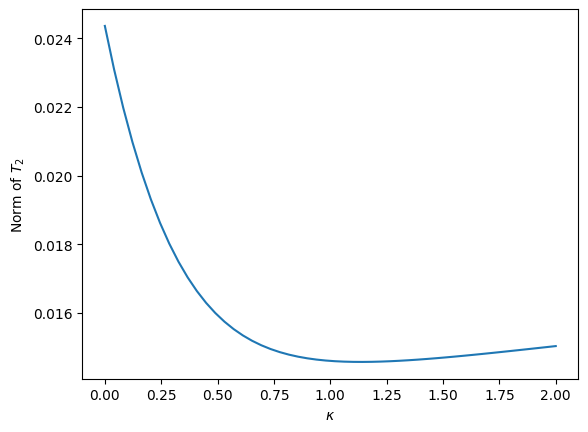

In [4]:
# this is for a given value of kappa, and we're asked to plot the absolute value of it's norm as a function of kappa
#so, we can do that by looping over kappa values and computing the norm of T2 for each value
kappas=np.linspace(0,2,50) # values of kappa to loop over (50 values between 0 and 1)
norms=[] # list to store the norms
for kappa in kappas: 
    # construct Liouvillian
    L=(1j*(np.kron(H,Id)-np.kron(Id,H.T))+ # Hamiltonian part (the commutator beetween H and rho)
       kappa*(nbar)*(2*np.kron(Ad,A.T)-np.kron(A@Ad,Id)-np.kron(Id,A@Ad))+ # Dissipator part due to absorption (gets population up)
       kappa*(nbar+1)*(2*np.kron(A,Ad.T)-np.kron(Ad@A,Id)-np.kron(Id,Ad@A))) # Dissipator part due to emission (gets population down)
    # exponentiate Liouvillian, dymanical map
    EL=expm(L*dt)
    EL2=expm(L*2*dt)
    Ea=Tracer@EL@Expander # single-time dynamical map for the 2LS
    Ea2=Tracer@EL2@Expander # two-time dynamical map for the 2LS
    T2=Ea2-Ea@Ea   
    norm=np.linalg.norm(T2) # compute norm of T2
    norms.append(norm) # store the norm
# plot the results
plt.plot(kappas,norms)
plt.xlabel(f'$\kappa$')
plt.ylabel(f'Norm of $T_2$')
plt.show()

??????????? explanation of the figure

In the class we were asked to come up with a test whether the atom is markovian or non-markovian (depending on the value of $g$, the coupling constant).
With the work done above we have more than enough to say if it's or not markovian for the given value of the coupling constant (we considered $g=0.1$), because the transfer tensor should be 0 in the case of a markovian evolution.
So, for $g=0.1$ we get $\forall \kappa \; |T_2|>0$ so it's clearly non-markovian.

But we can do something similar to the loop made to have different values of $\kappa$ but now concerning the coupling constant.

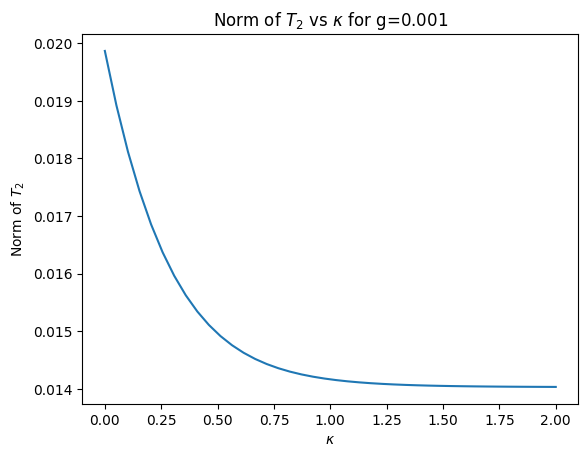

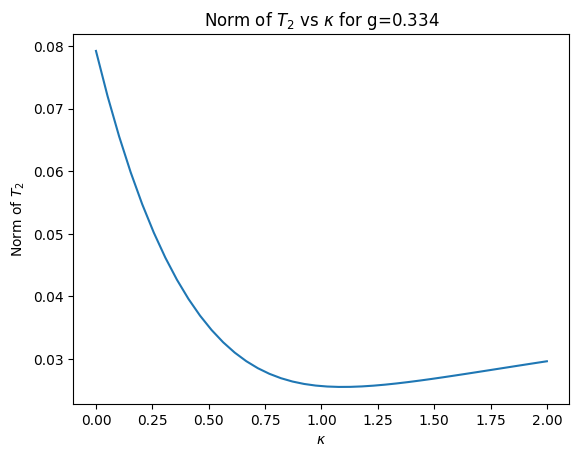

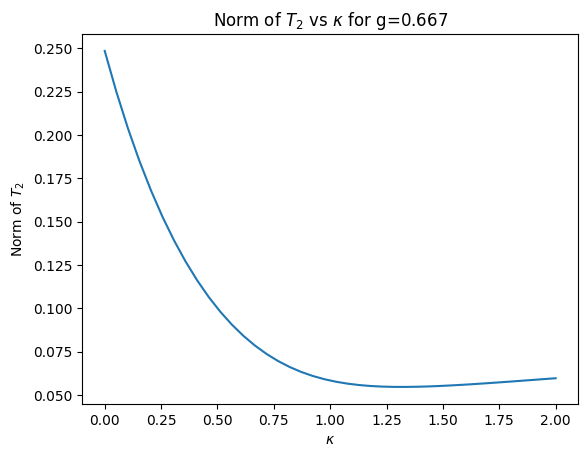

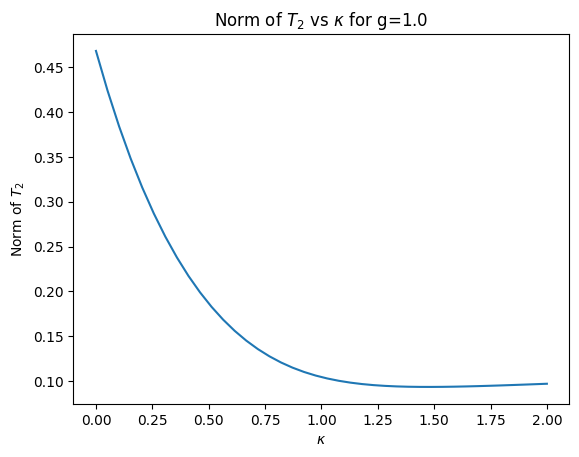

In [5]:
gs=np.linspace(0.001,1,4)
kappas=np.linspace(0,2,40) # values of kappa to loop over (50 values between 0 and 1)
for g in gs:
    norms=[] # list to store the norms
    # total Hamiltonian
    H=np.kron(Ha,Idv)+np.kron(Ida,Hv)+g*np.kron(sx,ad+a) # the position of the oscillator is proportional to (a+ad)    
    for kappa in kappas: 
        # construct Liouvillian
        L=(1j*(np.kron(H,Id)-np.kron(Id,H.T))+ # Hamiltonian part (the commutator beetween H and rho)
        kappa*(nbar)*(2*np.kron(Ad,A.T)-np.kron(A@Ad,Id)-np.kron(Id,A@Ad))+ # Dissipator part due to absorption (gets population up)
        kappa*(nbar+1)*(2*np.kron(A,Ad.T)-np.kron(Ad@A,Id)-np.kron(Id,Ad@A))) # Dissipator part due to emission (gets population down)
        # exponentiate Liouvillian, dymanical map
        EL=expm(L*dt)
        EL2=expm(L*2*dt)
        Ea=Tracer@EL@Expander # single-time dynamical map for the 2LS
        Ea2=Tracer@EL2@Expander # two-time dynamical map for the 2LS
        T2=Ea2-Ea@Ea   
        norm=np.linalg.norm(T2) # compute norm of T2
        norms.append(norm) # store the norm
    # plot the results
    plt.plot(kappas,norms)
    plt.xlabel(f'$\kappa$')
    plt.ylabel(f'Norm of $T_2$')
    plt.title(f'Norm of $T_2$ vs $\kappa$ for g={g}')
    plt.show()

The plots and the corresponding code may be printed and uploaded on a pdf. Label axes correctly. The analysis of the trend may be described in up to five handwritten lines with your own words.